# LLM - Meta - LLama

En este Notebook se realiza el proceso de transfer learning el modelo `llamma 3.2` y se evalúa sobre el conjunto de datos de ISEAR. La implementación de una versión fine-tuneada no fue posible con los recursos computacionales disponibles. (GPU 6GB en Máquina local, )


## Libraries


In [1]:
import transformers
from transformers import AutoTokenizer, set_seed
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
from transformers import (
    pipeline,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
)
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
import bitsandbytes as bnb
import os
from dotenv import load_dotenv

2024-11-06 15:48:04.487422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 15:48:04.646353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 15:48:04.688502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 15:48:05.106734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 15:48:11.344775: W tensorflow/compiler/tf2

## Hugging Face Authentication

Los modelos de meta son opensource pero se debe solicitar su acceso através de Kaggle o HuggingFace. En este caso se solicitaron por Hugging Face, por lo que es necesario autenticarse en la cuenta que tenga acceso.

Ver cómo solicitar accesos:

- **Kaggle**: Registrarse con el correo que se tiene en Kaggle en el siguiente enlace https://www.llama.com/llama-downloads/. Luego, ingresar a kaggle y agregar los modelos a un notebook en https://www.kaggle.com/organizations/metaresearch/models

- **Hugging Face**: Ir al _Model Card_ y llenar el formulario de solicitud (https://huggingface.co/meta-llama/Llama-3.2-1B)


In [4]:
from huggingface_hub import login

# Log in to Hugging Face using your API token

login(token=os.getenv("HUGGING_FACE_API_KEY"))

## Dataset

Se cargan los datasets de `training`, `validation` y `test`. Se utiliza cada uno para:

- `training` = Realizar el fine tunning del modelo.
- `validation` = validar el proceso de fine tunning.
- `test` = testear el modelo con nuevos datos.


In [2]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv").rename(
    columns={"emotion": "label"}
)
df_val = pd.read_csv("../data/data_to_model/val_data.csv").rename(
    columns={"emotion": "label"}
)
df_test = pd.read_csv("../data/data_to_model/test_data.csv").rename(
    columns={"emotion": "label"}
)

In [3]:
df_dict_test = Dataset.from_pandas(df_test)
df_dict_test = df_dict_test.class_encode_column("label")

Casting to class labels:   0%|          | 0/754 [00:00<?, ? examples/s]

Dado que es un proceso de Transfer Learning, se evalúa solo sobre el conjunto de datos de prueba para poder comparar los resultados con lo demás modelos.


## Prepare Data


In [ ]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
        You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
        You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
        [shame, sadness, joy, guilt, fear, disgust, anger].

        **Important Rules:**
        1. You must return only **one** of the emotions from the list without additional text.
        2. Do **not** create or infer any emotions outside the list.
        3. If the text does not match any emotion exactly, return the closest emotion from the list. 
        4. Do **not** return 'none', 'jealousy', or any other emotion that is not in the list.
        5. Do not return additional text, only **exactly one emotion** of the list.
        
        Your answer can only be shame, sadness, joy, guilt, fear, disgust, or anger.
        If you're unsure, assign the closest emotion from the allowed list.
        
text: {data_point["text"]}
label: {data_point["label"]}""".strip()


def generate_test_prompt(data_point):
    return f"""
        You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
        You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
        [shame, sadness, joy, guilt, fear, disgust, anger].
text: {data_point["text"]}
label: """.strip()

In [5]:
df_train["text"] = df_train.apply(generate_prompt, axis=1)
df_val["text"] = df_val.apply(generate_prompt, axis=1)
df_test["text"] = df_test.apply(generate_test_prompt, axis=1)

# Generate prompts for training and evaluation data
X_train = df_train["text"]
X_val = df_val["text"]
X_test = df_test["text"]

# Generate test prompts and extract true labels
y_test = df_test.loc[:, "label"]

## `llama-3.2-1B-Instruct`

### Loading model and tokenizer


In [ ]:
base_model_name = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

### Model Evaluation with Transfer Learning


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["shame", "sadness", "joy", "guilt", "fear", "disgust", "anger"]

    for i in X_test:
        prompt = i
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=0.1,
        )

        result = pipe(prompt)
        answer = result[0]["generated_text"].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred


y_pred = predict(X_test, model, tokenizer)

In [ ]:
len([x for x in y_pred if x == "none"])

370

370 predicciones estuvieron por fuera de las respuestas aceptadas por lo que se descarta este modelo.


## `llama-3.2-1B`


In [ ]:
base_model_name = "meta-llama/Llama-3.2-1B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

### Model Evaluation with Transfer Learning


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["shame", "sadness", "joy", "guilt", "fear", "disgust", "anger"]

    for i in X_test:
        prompt = i
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=0.1,
        )

        result = pipe(prompt)
        answer = result[0]["generated_text"].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred


y_pred = predict(X_test, model, tokenizer)

In [ ]:
len([x for x in y_pred if x == "none"])

237

370 predicciones estuvieron por fuera de las respuestas aceptadas por lo que se descarta este modelo.


## `llama-3.1-8B`


In [ ]:
base_model_name = "meta-llama/Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="cuda",
    torch_dtype="float16",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Model Evaluation with Transfer Learning


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["shame", "sadness", "joy", "guilt", "fear", "disgust", "anger"]

    for i in X_test:
        prompt = i
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=0.1,
        )

        result = pipe(prompt)
        answer = result[0]["generated_text"].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred


y_pred = predict(X_test, model, tokenizer)

In [ ]:
len([x for x in y_pred if x == "none"])

0

array(['anger', 'sadness', 'shame', 'guilt', 'disgust', 'fear', 'joy'],
      dtype=object)

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

       anger       0.52      0.64      0.58       109
     sadness       0.82      0.46      0.59       107
       shame       0.91      0.72      0.80       109
       guilt       0.66      0.50      0.57       106
     disgust       0.87      0.93      0.90       109
        fear       0.60      0.81      0.69       108
         joy       0.53      0.66      0.59       106

    accuracy                           0.67       754
   macro avg       0.70      0.67      0.67       754
weighted avg       0.70      0.67      0.67       754



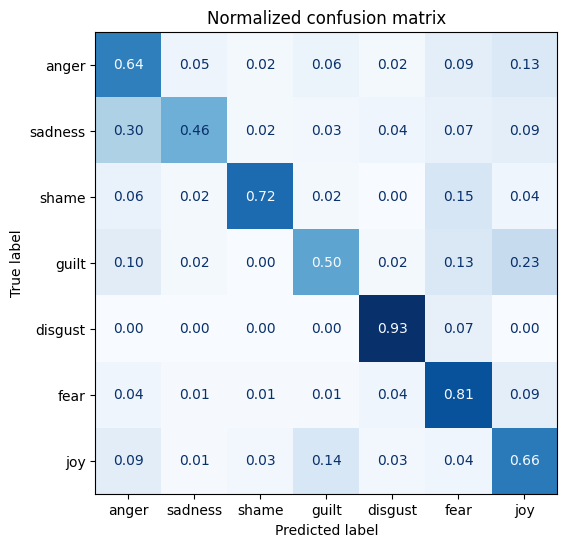

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,meta-llama/Llama-3.1-8B-Instruct,Fine Tuning,0.67374,0.700774,0.672612,0.671986


In [ ]:
# Initialize an empty list to store results
results = []
labels = y_test.unique()

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": base_model_name,
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

plot_confusion_matrix(y_pred, y_test, labels)

results_df

In [16]:
results_df.to_excel("../data/model_results/meta-llama.xlsx", index=False)